In [1]:
import pathlib
import pandas as pd
import numpy as np
from itertools import combinations
import os
from tqdm import tqdm
import requests
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data_path = data_path = pathlib.Path().resolve().parent.parent / "rn_home" / "data"
rlpolk_data_path = data_path / "rlpolk_data"
vin_matching_path = data_path / "vin_matching"

# Define required functions

In [2]:
def try_divide(a,b, num =2):
    try:
        return round(a/b,num)
    except:
        return np.NaN

In [3]:
def expand_df(df, oldyear, newyear):
    df_cut = df.loc[df["year"]==oldyear,:]
    df_cut["year"] = newyear
    df_out = pd.concat([df, df_cut])
    return df_cut

# Import data

In [4]:
rlp_raw = pd.read_csv(rlpolk_data_path / "rlpolk_data_matched.csv", index_col = [0])
evs_raw = rlp_raw[rlp_raw["Fuel Type - Primary"]=="Electric"]

In [5]:
rlp = rlp_raw.copy(deep=True)

# Quality check - Price Data

In [6]:
# Check how many vehicles in the dataset have a price attached to them
price_mask = evs_raw["TRANSACTION_PRICE"].notna()
vehs_price = evs_raw[price_mask]["VEH_COUNT"].sum()
vehs_noprice = evs_raw[~price_mask]["VEH_COUNT"].sum()
print(f"{vehs_price/(vehs_noprice+vehs_price) * 100:0.2f}% of vehicles have a price")

77.11% of vehicles have a price


In [7]:
# Count vehicles with and without prices
rlp_price_mask = rlp_raw["TRANSACTION_PRICE"].notna()
rlp.loc[rlp_price_mask, "vehs_with_price"] = rlp.loc[rlp_price_mask, "VEH_COUNT"]
rlp.loc[~rlp_price_mask, "vehs_with_price"] = 0
rlp.loc[~rlp_price_mask, "vehs_without_price"] = rlp.loc[~rlp_price_mask, "VEH_COUNT"]
rlp.loc[rlp_price_mask, "vehs_without_price"] = 0

# Price Dispersion Analysis

In [135]:
# Prepare for grouping
ev_price_disp = rlp[rlp["Fuel Type - Primary"] == "Electric"]
ev_price_disp = ev_price_disp[ev_price_disp["vehs_with_price"] > 0]

In [ ]:
ev_price_disp = ev_price_disp[["year", "month", "vin_corrected", "VEH_COUNT", "TRANSACTION_PRICE"]]

# Get sums, means, vars
ev_price_disp_sums =  ev_price_disp.groupby(["year", "month", "vin_corrected"]).sum().reset_index()[["year", "month", "vin_corrected", "VEH_COUNT"]]
ev_price_disp_sums = ev_price_disp_sums.rename(columns = {"VEH_COUNT":"total_sold"})

ev_price_disp_means = ev_price_disp.groupby(["year", "month", "vin_corrected"]).mean().reset_index()[["year", "month", "vin_corrected", "TRANSACTION_PRICE"]]
ev_price_disp_means = ev_price_disp_means.rename(columns = {"TRANSACTION_PRICE":"mean_price"})

ev_price_disp_maxs= ev_price_disp.groupby(["year", "month", "vin_corrected"]).max().reset_index()[["year", "month", "vin_corrected", "TRANSACTION_PRICE"]]
ev_price_disp_maxs = ev_price_disp_maxs.rename(columns = {"TRANSACTION_PRICE":"max_price"})

ev_price_disp_mins= ev_price_disp.groupby(["year", "month", "vin_corrected"]).min().reset_index()[["year", "month", "vin_corrected", "TRANSACTION_PRICE"]]
ev_price_disp_mins = ev_price_disp_mins.rename(columns = {"TRANSACTION_PRICE":"min_price"})

ev_price_disp_vars = ev_price_disp.groupby(["year", "month", "vin_corrected"]).std().reset_index()[["year", "month", "vin_corrected", "TRANSACTION_PRICE"]]
ev_price_disp_vars = ev_price_disp_vars.rename(columns = {"TRANSACTION_PRICE":"sd_price"})

# Create analysis
ev_price_disp_full = ev_price_disp_sums.merge(ev_price_disp_means,
                                              right_on = ["year", "month", "vin_corrected"],
                                              left_on = ["year", "month", "vin_corrected"],
                                              how = 'left')

ev_price_disp_full = ev_price_disp_full.merge(ev_price_disp_vars,
                                              right_on = ["year", "month", "vin_corrected"],
                                              left_on = ["year", "month", "vin_corrected"],
                                              how = 'left')

ev_price_disp_full = ev_price_disp_full.merge(ev_price_disp_maxs,
                                              right_on = ["year", "month", "vin_corrected"],
                                              left_on = ["year", "month", "vin_corrected"],
                                              how = 'left')

ev_price_disp_full = ev_price_disp_full.merge(ev_price_disp_mins,
                                              right_on = ["year", "month", "vin_corrected"],
                                              left_on = ["year", "month", "vin_corrected"],
                                              how = 'left')


ev_price_disp_full = ev_price_disp_full[ev_price_disp_full["total_sold"]>1]
ev_price_disp_full.dropna(subset = ["sd_price"], inplace = True)
ev_price_disp_full["sd_price"] = ev_price_disp_full["sd_price"].astype(int)

ev_price_disp_full["sd_pct_mean"] = ev_price_disp_full["sd_price"] / ev_price_disp_full["mean_price"]
ev_price_disp_full["difference"] = ev_price_disp_full["max_price"] -  ev_price_disp_full["min_price"]

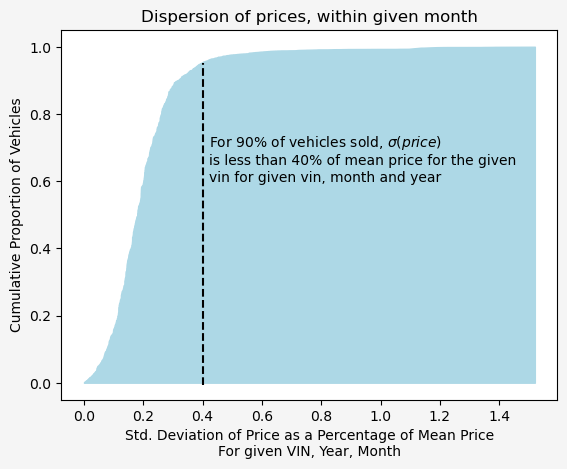

In [133]:
test = ev_price_disp_full[["total_sold", "sd_pct_mean"]].sort_values("sd_pct_mean")
test["cumulative"] = test["total_sold"].cumsum(axis = 0)


# Fig
fig, ax = plt.subplots(nrows = 1, ncols = 1, facecolor = 'whitesmoke')
ax.fill_between(test["sd_pct_mean"], test["cumulative"]/max(test["cumulative"]), 0, color = 'lightblue')
ax.set_title("Dispersion of prices, within given month")
ax.set_xlabel("Std. Deviation of Price as a Percentage of Mean Price\nFor given VIN, Year, Month")
ax.set_ylabel("Cumulative Proportion of Vehicles")
ax.axvline(x=0.4, ymin = 0.04, ymax=0.91, linestyle ="--", color = 'black')
ax.text(0.42, 0.6, "For 90% of vehicles sold, $\sigma(\t{price})$\nis less than 40% of mean price for the given\nvin for given vin, month and year")
fig.show()

In [134]:
ev_price_disp_full

,year,month,vin_corrected,total_sold,mean_price,sd_price,max_price,min_price,sd_pct_mean,difference
1,2018,1,1G1FW6S0*H,4,34886.750000,5721,38789.0,26431.0,0.163988,12358.0
2,2018,1,1G1FX6S0*H,10,40797.777778,1412,42869.0,37737.0,0.034610,5132.0
4,2018,1,1G1RC6S5*H,3,29270.333333,9633,38104.0,18998.0,0.329105,19106.0
5,2018,1,1G1RC6S5*J,2,33782.500000,1833,35079.0,32486.0,0.054259,2593.0
6,2018,1,1G1RD6S5*H,3,39055.000000,8309,47450.0,30833.0,0.212751,16617.0
...,...,...,...,...,...,...,...,...,...,...
3578,2022,12,YV4ED3UM*P,3,60485.000000,722,61315.0,60000.0,0.011937,1315.0
3579,2022,12,YV4H60CA*P,2,79984.500000,10310,87275.0,72694.0,0.128900,14581.0
3581,2022,12,YV4H60DA*P,2,63282.000000,8113,69019.0,57545.0,0.128204,11474.0
3584,2022,12,YV4H60DW*P,4,50233.000000,16334,63477.0,26835.0,0.325165,36642.0


# Group Data

We need our observations to be by:
* Type (electric)
* Zip code
* Year & month
Along with the average transaction price

In [13]:
# Prepare for grouping
rlp_for_group = rlp[["ZIP_CODE", "year", "month", "Fuel Type - Primary", "VEH_COUNT", "vehs_with_price", "vehs_without_price", "TRANSACTION_PRICE"]]

# Group to get counts and averages
rlp_grouped = rlp_for_group.groupby(["ZIP_CODE", "year", "month", "Fuel Type - Primary"], dropna = False).sum().reset_index().reset_index(drop=True)
rlp_grouped["avg_transaction_price"] = rlp_grouped.apply(lambda x: try_divide(x.TRANSACTION_PRICE, x.vehs_with_price), axis =1)

In [14]:
# Get evs
evs_grouped = rlp_grouped[rlp_grouped["Fuel Type - Primary"] == "Electric"]
evs_grouped["year"] = evs_grouped["year"].astype(int)

# Observe

In [11]:
# Get counts
counts_df = evs_grouped.groupby(["year", "month", "ZIP_CODE"]).sum().reset_index().reset_index(drop=True)[["year", "month", "ZIP_CODE", "VEH_COUNT"]]
raw_counts = counts_df["VEH_COUNT"].to_list()
raw_counts_trunc = [x for x in raw_counts if x>1]

**Observe counts**

In [12]:
counts,bins = np.histogram(raw_counts, bins = 20)
counts_trunc, bins_trunc = np.histogram(raw_counts_trunc, bins = 10)

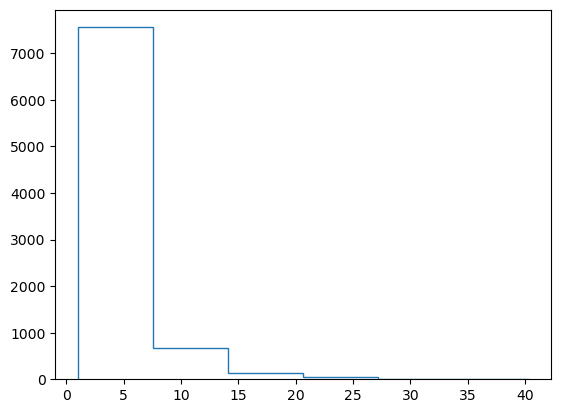

In [13]:
plt.stairs(counts[0:6],bins[0:7])

In [14]:
print(f"We have clear overdispersion with E[counts]={np.mean(raw_counts):0.2f} and Var[counts]={np.var(raw_counts):0.2f}")

We have clear overdispersion with E[counts]=3.64 and Var[counts]=22.04


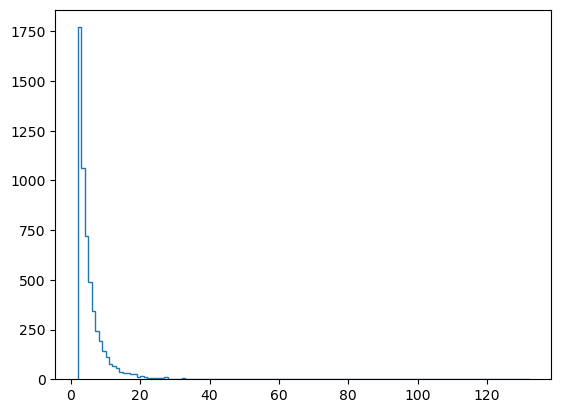

In [15]:
plt.stairs(np.unique(np.array(raw_counts_trunc), return_counts = True)[1][0:47], np.unique(np.array(raw_counts_trunc), return_counts = True)[0])

In [16]:
print(f"When truncated E[counts]={np.mean(raw_counts_trunc):0.2f} and Var[counts]={np.var(raw_counts_trunc):0.2f}")

When truncated E[counts]=5.03 and Var[counts]=28.09


In [41]:
evs_grouped

,ZIP_CODE,year,month,Fuel Type - Primary,VEH_COUNT,vehs_with_price,vehs_without_price,TRANSACTION_PRICE,avg_transaction_price
1,6001,2018,1,Electric,3,2.0,1.0,127479.0,63739.50
6,6001,2018,3,Electric,6,2.0,4.0,58293.0,29146.50
9,6001,2018,4,Electric,7,6.0,1.0,212794.0,35465.67
12,6001,2018,5,Electric,1,1.0,0.0,28504.0,28504.00
14,6001,2018,6,Electric,4,2.0,2.0,54162.0,27081.00
...,...,...,...,...,...,...,...,...,...
35991,6907,2022,8,Electric,3,3.0,0.0,164713.0,54904.33
35995,6907,2022,9,Electric,2,2.0,0.0,148069.0,74034.50
35998,6907,2022,10,Electric,4,3.0,1.0,139301.0,46433.67
36001,6907,2022,11,Electric,4,2.0,2.0,102634.0,51317.00


,ZIP_CODE,year,month,Fuel Type - Primary,VEH_COUNT,vehs_with_price,vehs_without_price,TRANSACTION_PRICE,avg_transaction_price
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Add zeros

In [15]:
empty_row = evs_grouped.iloc[[0]]
empty_row.iloc[0, 4:] = np.NaN

In [74]:
def add_zero_observations(input_df, zips, years, months):
    out_df = input_df.copy()
    for zip in tqdm(zips):
        for year in sorted(years):
            for month in sorted(months):
                mask = (out_df["ZIP_CODE"]==zip) & (out_df["year"]==year) & (out_df["month"] == month)
                contained = sum(mask) == 1
                if not contained:
                    row_to_add = empty_row
                    row_to_add["ZIP_CODE"] = zip
                    row_to_add["year"] = year
                    row_to_add["month"]=  month
                    row_to_add.iloc[0, 4:7] = 0
                    out_df = pd.concat([out_df, row_to_add]).reset_index(drop=True)
    out_df.sort_values(["ZIP_CODE", "year", "month"], inplace = True)
    out_df = out_df.reset_index(drop = True)
    return out_df

In [75]:
evs_grouped_zeros = add_zero_observations(evs_grouped, evs_grouped["ZIP_CODE"].unique().tolist(), evs_grouped["year"].unique().tolist(), evs_grouped["month"].unique().tolist())

100%|██████████| 287/287 [00:38<00:00,  7.38it/s]


# Attempt merge to percentages

In [127]:
evs_bg_merge = evs_grouped.merge(mun_evs_zipgroups[["Postal", "GEOID", "pct_within_zip"]],
                                 left_on = "ZIP_CODE",
                                 right_on = "Postal",
                                 how = "outer")

,ZIP_CODE,year,month,Fuel Type - Primary,VEH_COUNT,vehs_with_price,vehs_without_price,TRANSACTION_PRICE,avg_transaction_price,Postal,GEOID,pct_within_zip
0,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003460e+10,0.009259
1,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.003086
2,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.104938
3,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.064815
4,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.037037
...,...,...,...,...,...,...,...,...,...,...,...,...
793,6001.0,2022.0,12.0,Electric,16.0,13.0,3.0,743054.0,57158.0,6001.0,9.003462e+10,0.064815
794,6001.0,2022.0,12.0,Electric,16.0,13.0,3.0,743054.0,57158.0,6001.0,9.003462e+10,0.157407
795,6001.0,2022.0,12.0,Electric,16.0,13.0,3.0,743054.0,57158.0,6001.0,9.003462e+10,0.145062
796,6001.0,2022.0,12.0,Electric,16.0,13.0,3.0,743054.0,57158.0,6001.0,9.003466e+10,0.012346


In [136]:
evs_bg_merge[(evs_bg_merge["ZIP_CODE"]==6001) & (evs_bg_merge["year"]==2018) & (evs_bg_merge["month"]==1)]

,ZIP_CODE,year,month,Fuel Type - Primary,VEH_COUNT,vehs_with_price,vehs_without_price,TRANSACTION_PRICE,avg_transaction_price,Postal,GEOID,pct_within_zip
0,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003460e+10,0.009259
1,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.003086
2,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.104938
3,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.064815
4,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.037037
5,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.067901
6,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.169753
7,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.117284
8,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.043210
9,6001.0,2018.0,1.0,Electric,3.0,2.0,1.0,127479.0,63739.5,6001.0,9.003462e+10,0.064815


# Covariates prepare

In [18]:
income_data_path = data_path / "data_for_poisson" / "ACSS1901 - Income - By ZCTA"
population_data_path = data_path / "data_for_poisson" / "ACSB01003 - Total Population - By ZCTA"
zip_area_data_path = data_path / "data_for_poisson" / "zctas_2019_areas.csv"
education_data_path = data_path / "data_for_poisson" / "ACSS1501 - Educational Attainment - By ZCTA"

**Need to fix this**

In [16]:
def fix_income_df(input):
    out = input.replace(',', '')
    try:
        return int(out)
    except:
        return np.NaN

In [19]:
income_df = pd.DataFrame()

for file in income_data_path.iterdir():
    # Get the year
    year = file.name[7:11]

    # Read in the file and get the median income
    f = pd.read_csv(file, thousands = ',')
    f = f.iloc[[11]].T.reset_index()
    f = f.loc[f["index"].str.contains("Households!!Estimate")]

    # Get the zip code and year, and rename columns
    f["index"] = f["index"].str[6:11].astype(int)
    f["year"] = int(year)
    f = f.rename(columns = {"index" : "zip", 11: "median_income"}).reset_index(drop = True)
    f["median_income"] = f["median_income"].apply(lambda x: fix_income_df(x))

    # Append to the master df
    income_df = pd.concat([income_df, f]).reset_index(drop = True)

In [20]:
income_df = pd.concat([income_df, expand_df(income_df, 2021, 2022)])

In [21]:
population_df = pd.DataFrame()

for file in population_data_path.iterdir():
    # Get the year
    year = file.name[7:11]

    # Read in the file and get the population
    f = pd.read_csv(file, thousands = ',')
    f = f.T.reset_index()
    f = f.loc[f["index"].str.contains("Estimate")]

    # Get the zip code and year, and rename columns
    f["index"] = f["index"].str[6:11].astype(int)
    f["year"] = int(year)
    f = f.rename(columns = {"index" : "zip", 0: "population"}).reset_index(drop = True)
    f["population"] = f["population"].astype(int)

    # Append to the master df
    population_df = pd.concat([population_df, f]).reset_index(drop = True)

In [22]:
zip_areas = pd.read_csv(zip_area_data_path, index_col = [0]).reset_index(drop=True)[["ZCTA5CE10","Area_km2"]].rename(columns={"ZCTA5CE10":"zip"})
zip_areas = zip_areas.loc[zip_areas["zip"].astype(str).str[0:4].str.zfill(5).str[0:2]=="06"]
zip_areas["Area_km2"] = zip_areas["Area_km2"].astype(float)

In [23]:
population_df = population_df.merge(zip_areas,
                                    left_on = "zip",
                                    right_on = "zip",
                                    how = "left")

In [24]:
population_df

,zip,population,year,Area_km2
0,6001,18561,2017,61.577189
1,6002,20848,2017,67.930523
2,6010,60498,2017,69.416639
3,6013,9598,2017,78.783841
4,6016,7003,2017,39.016399
...,...,...,...,...
1411,6902,69523,2021,32.478960
1412,6903,14816,2021,47.280737
1413,6905,21604,2021,12.900674
1414,6906,10847,2021,3.131654


In [25]:
# Add density
population_df["pop_density"] = population_df.apply(lambda x: try_divide(x.population, x.Area_km2), axis = 1)

# Add in 2022
population_df = pd.concat([population_df, expand_df(population_df, 2021, 2022)])

In [26]:
education_data_df = pd.DataFrame()

In [27]:
for file in education_data_path.iterdir():
    # Get the year
    year = file.name[7:11]

    # Read in the file and get the population
    f = pd.read_csv(file, skiprows =[0])
    col1 = "Geographic Area Name"
    col2 = "Estimate!!Percent!!Population 25 years and over!!High school graduate (includes equivalency)"
    col2a = "Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency)"
    
    try:
        f = f[[col1, col2]]
    except:
        f = f[[col1, col2a]]

    f = f.rename(columns = {f.columns[0]:"zip", f.columns[1]:"pct_over25_hs"}).reset_index(drop=True)
    f["zip"] = f["zip"].str[6:].astype(int)
    f["year"] = int(year)
    education_data_df = pd.concat([education_data_df, f]).reset_index(drop=True)

In [28]:
education_data_df = pd.concat([education_data_df, expand_df(education_data_df, 2021, 2022)])

# Merge

In [29]:
def merge_covariates(input_df):
    out_df = input_df.copy()

    # Merge in population
    out_df = out_df.merge(population_df,
                        left_on = ["ZIP_CODE", "year"],
                        right_on = ["zip","year"],
                        how = "left")
    # Merge in education
    out_df = out_df.merge(education_data_df,
                            left_on = ["ZIP_CODE", "year"],
                            right_on = ["zip","year"],
                            how = "left")

    # Add income data
    out_df = out_df.merge(income_df,
                            left_on = ["ZIP_CODE", "year"],
                            right_on = ["zip","year"],
                            how = "left")

    # Fix things
    out_df = out_df.drop("zip_x", axis = 1)
    out_df = out_df.drop("zip_y", axis = 1)
    out_df = out_df.drop("zip", axis = 1)

    # Drop NA
    out_df = out_df.dropna()
    return out_df

In [101]:
evs_grouped_merge_zeros = merge_covariates(evs_grouped_zeros)

In [30]:
evs_grouped_merge = merge_covariates(evs_grouped)

In [31]:
check_na_mask = evs_grouped_merge["Area_km2"].isna()| evs_grouped_merge["pct_over25_hs"].isna() | evs_grouped_merge["median_income"].isna()
print(f"A total of {len(evs_grouped_merge[check_na_mask])} rows with missing data, or {check_na_mask.sum() / len(evs_grouped_merge):0.4f}%")

A total of 0 rows with missing data, or 0.0000%


In [111]:
len(evs_grouped)

8467

In [112]:
len(evs_grouped_merge)

7643

In [88]:
evs_grouped_merge.to_csv(data_path / "data_for_poisson"/ "poisson_data_112023.csv")

In [2]:
evs_grouped_merge = pd.read_csv("poisson_data_112023.csv", index_col = [0])

# Descriptives

## Observe zeros

In [32]:
# Calculate zeros per month and year
zeros_per_year = evs_grouped_merge_zeros[evs_grouped_merge_zeros["VEH_COUNT"]==0].groupby(["year", "month"]).count()[["ZIP_CODE"]].reset_index()
zeros_per_year["date"] = pd.date_range("2018-01-01", periods = 60, freq = "M")

# Create plot
fig, ax = plt.subplots(nrows = 1, ncols =1, facecolor = 'whitesmoke')
ax2 = ax.twinx()

# Add lines
ax.plot( zeros_per_year["date"], zeros_per_year["ZIP_CODE"])
ax2.plot(zeros_per_year["date"], zeros_per_year["ZIP_CODE"]/287, linewidth = 0)

# Labels and title
ax.set_ylabel("Number of Zip Codes")
ax2.set_ylabel("Percentage of Zip Codes")
ax.set_xlabel("Date")
# ax.set_ylim((0, 287))
# ax2.set_ylim((0,1))
ax.set_title("Number and Percentage of Zip codes with zero EV sales")

# Show
plt.show()

NameError: name 'evs_grouped_merge_zeros' is not defined

## Dispersion analysis
Note: Not controlling for month, not controlling for before and after COVID

In [35]:
evs_grouped_merge["VEH_COUNT"].var()

23.07067123870395

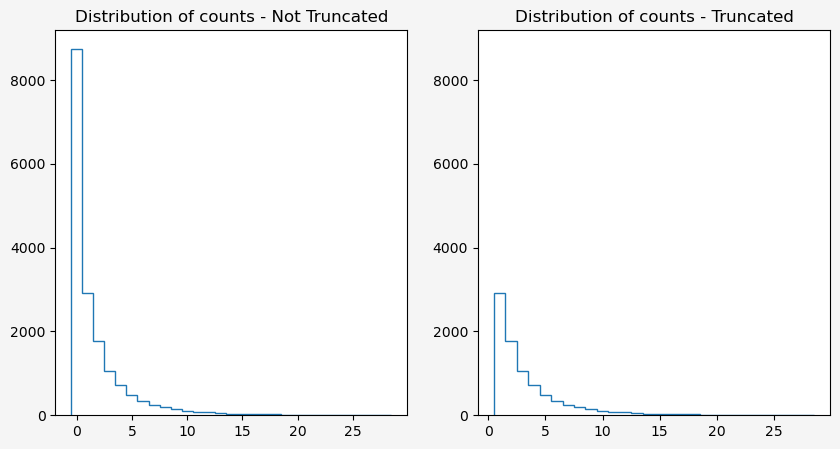

In [213]:
fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (10,5), facecolor = 'whitesmoke')
ax[0].stairs(np.unique(np.array(evs_grouped_merge_zeros["VEH_COUNT"]), return_counts = True)[1][0:29]-0.5, np.unique(np.array(evs_grouped_merge_zeros["VEH_COUNT"]), return_counts = True)[0][0:30]-0.5)
ax[1].stairs(np.unique(np.array(evs_grouped_merge_zeros["VEH_COUNT"]), return_counts = True)[1][1:29]-0.5, np.unique(np.array(evs_grouped_merge_zeros["VEH_COUNT"]), return_counts = True)[0][1:30]-0.5)
ax[0].set_title("Distribution of counts - Not Truncated")
ax[1].sharey(ax[0])
ax[1].set_title("Distribution of counts - Truncated")
fig.show()

### Dispersion by zip

In [245]:
expecteds = evs_grouped_merge_zeros.groupby("ZIP_CODE")["VEH_COUNT"].mean()
vars = evs_grouped_merge_zeros.groupby("ZIP_CODE")["VEH_COUNT"].var()
sales = evs_grouped_merge_zeros.groupby("ZIP_CODE")["VEH_COUNT"].sum()
dispersion = pd.DataFrame([expecteds, vars, sales]).T.reset_index()
dispersion.columns= ["ZIP_CODE","expected", "variance", "sales"]
# dispersion["difference"] = dispersion["expected"] - dispersion["variance"]
dispersion["var_pct_expected"] = abs(dispersion["variance"] / dispersion["expected"])*100
# dispersion.sort_values("var_pct_expected", ascending = False).head(15).reset_index(drop=True)

dispersion[~(dispersion["var_pct_expected"]>50) | ~(dispersion["var_pct_expected"]<150)]["sales"].sum()

# Analysis
# dispersion[abs(dispersion["difference"]) < (1*abs(dispersion["expected"]))]

26773.0

# Test Poisson

In [57]:
from sklearn.linear_model import PoissonRegressor

In [58]:
model = PoissonRegressor()

In [204]:
evs_grouped_merge

,ZIP_CODE,year,month,Fuel Type - Primary,VEH_COUNT,vehs_with_price,vehs_without_price,TRANSACTION_PRICE,avg_transaction_price,population,Area_km2,pct_over25_hs,median_income
0,6001,2018,1,Electric,3,2.0,1.0,127479.0,63739.50,18532.0,61.577189,10.1,"129,888"
1,6001,2018,3,Electric,6,2.0,4.0,58293.0,29146.50,18532.0,61.577189,10.1,"129,888"
2,6001,2018,4,Electric,7,6.0,1.0,212794.0,35465.67,18532.0,61.577189,10.1,"129,888"
3,6001,2018,5,Electric,1,1.0,0.0,28504.0,28504.00,18532.0,61.577189,10.1,"129,888"
4,6001,2018,6,Electric,4,2.0,2.0,54162.0,27081.00,18532.0,61.577189,10.1,"129,888"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8462,6907,2022,8,Electric,3,3.0,0.0,164713.0,54904.33,8849.0,5.414747,20.7,"99,861"
8463,6907,2022,9,Electric,2,2.0,0.0,148069.0,74034.50,8849.0,5.414747,20.7,"99,861"
8464,6907,2022,10,Electric,4,3.0,1.0,139301.0,46433.67,8849.0,5.414747,20.7,"99,861"
8465,6907,2022,11,Electric,4,2.0,2.0,102634.0,51317.00,8849.0,5.414747,20.7,"99,861"


In [71]:
y = evs_grouped_merge.dropna()
y = y["VEH_COUNT"].to_numpy()
x = evs_grouped_merge.dropna()
x["population"] = x["population"]/1000
x["median_income"] = x["median_income"]/10000
x["pop_density"] = x["pop_density"]/100
x = x[["population", "pct_over25_hs", "median_income", "pop_density"]].to_numpy()

In [73]:
model.fit(x,y)

PoissonRegressor()

In [74]:
model.intercept_, model.coef_

(0.3609378626614327,
 array([ 0.03113661, -0.02208575,  0.07635376, -0.00382444]))

In [75]:
predicted = model.predict(x)

In [76]:
pd.DataFrame([y, predicted]).T

,0,1
0,3.0,5.447350
1,6.0,5.447350
2,7.0,5.447350
3,1.0,5.447350
4,4.0,5.447350
...,...,...
7638,3.0,2.409132
7639,2.0,2.409132
7640,4.0,2.409132
7641,4.0,2.409132


# Getting right columns

In [9]:
education_cols = []
for file in education_data_path.iterdir():
    f = pd.read_csv(file, skiprows = [0])
    cols = f.columns.tolist()
    a = [x for x in cols if "Percent" in x and "High school graduate" in x and not"Annotation" in x and not "Margin" in x and not "RACE" in x]
    a = [x for x in a if "25 years and over" in x]
    a = [x for x in a if not "Male" in x and not "Female" in x]
    a = [x for x in a if not "to" in x]
    education_cols.append([a])

In [10]:
education_cols

[[['Estimate!!Percent!!Population 25 years and over!!High school graduate (includes equivalency)',
   'Estimate!!Percent!!Population 25 years and over!!Population 65 years and over!!High school graduate or higher',
   'Estimate!!Percent!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!High school graduate (includes equivalency)']],
 [['Estimate!!Percent!!Population 25 years and over!!High school graduate (includes equivalency)',
   'Estimate!!Percent!!Population 25 years and over!!High school graduate or higher',
   'Estimate!!Percent!!Population 25 years and over!!Population 65 years and over!!High school graduate or higher',
   'Estimate!!Percent!!MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Population 25 years and over with earnings!!High school graduate (includes equivalency)']],
 [['Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school gradua

# (Old) Prepare block group allocations

In [33]:
mun_evs = pd.read_csv(data_path / "municipal_evs_zips_blockgroups" / "evs_geocoded_zip_blockgroup.csv")

In [34]:
cols_keep = ['Status', 'Region', 'Postal', 'PostalExt', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID']
mun_evs = mun_evs.loc[:,cols_keep]
mun_evs = mun_evs.loc[(mun_evs["Region"]=="Connecticut") & (mun_evs["Status"]=="M"), :]
mun_evs["Postal"] = mun_evs["Postal"].astype(int)

In [35]:
mun_evs_zipgroups = mun_evs.groupby(["Postal", "GEOID"]).count().reset_index()[["Postal", "GEOID", "Status"]].rename(columns={"Status":"Count"})

In [36]:
mun_evs_zipgroups["pct_within_zip"] = mun_evs_zipgroups["Count"] / mun_evs_zipgroups.groupby("Postal")["Count"].transform('sum')

In [37]:
mun_evs_zipgroups[["Postal", "GEOID", "pct_within_zip"]]

,Postal,GEOID,pct_within_zip
0,6001,9.003460e+10,0.009259
1,6001,9.003462e+10,0.003086
2,6001,9.003462e+10,0.104938
3,6001,9.003462e+10,0.064815
4,6001,9.003462e+10,0.037037
...,...,...,...
2441,6907,9.001021e+10,0.113208
2442,6907,9.001021e+10,0.245283
2443,6907,9.001021e+10,0.094340
2444,6907,9.001021e+10,0.037736


In [10]:
rlp_zips = evs_raw["ZIP_CODE"].unique().tolist()